In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np

C:\Users\shant\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
train_path = './Data/chest_xray/train'
dev_path = './Data/chest_xray/test'
val_path = './Data/chest_xray/val'


In [3]:
os.listdir('./Data/chest_xray/test')

['NORMAL', 'PNEUMONIA']

In [24]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])

In [25]:
train_set = torchvision.datasets.ImageFolder(root = train_path,transform = train_transforms)

In [73]:
train_loader = torch.utils.data.DataLoader(dataset = train_set,batch_size = 16,shuffle=False)

In [74]:
#Getting mean and std to apply normalization on the images

def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_imgs_count=0
    for imgs,_ in loader:
        imgs_count= imgs.size(0)
        imgs = imgs.view(imgs_count,imgs.size(1),-1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        total_imgs_count += imgs_count
    
    mean /= total_imgs_count
    std /= total_imgs_count
    return mean,std
    
    

In [75]:
mean,std = get_mean_and_std(train_loader)

In [76]:
print(mean)
std

tensor([0.4823, 0.4823, 0.4823])


tensor([0.2216, 0.2216, 0.2216])

In [77]:
#We reload the data with more transformation and augumentation

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(0.3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.RandomHorizontalFlip(0.3),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])

In [191]:
#Load data
train_set = torchvision.datasets.ImageFolder(root = train_path,transform=train_transforms)
test_set = torchvision.datasets.ImageFolder(root = train_path,transform=test_transforms)

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=16,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])


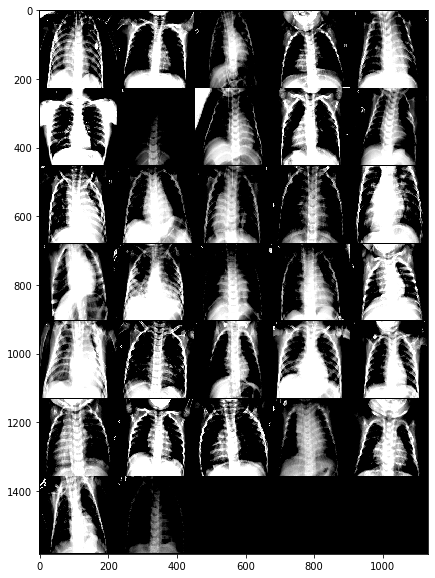

In [192]:
#Display some part of the transformed dataset

images,labels =next(iter(train_loader))

grid = torchvision.utils.make_grid(images,nrow=5)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid,(1,2,0)))
print('labels:',labels)
    

In [193]:
#Set to GPU if possible
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda'
    else:
        dev = 'cpu'
    return torch.device(dev)
print(set_device())


cuda


In [198]:
#Define nn class
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #Input=3 x 224 x 224, Output = 16 x 220 x 220 
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5),
            nn.ReLU(),
            #Input = 16 x220 x 220  , Output = 16 x 110 x 110
            nn.MaxPool2d(2,stride=1),

            #Input = 16 x 110 x 110, Output = 32 x 108 x 108 
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,padding=1),
            nn.ReLU(),
            
            #Input = 32 x 108 x 108, Output = 32 x 54 x 54 
            nn.MaxPool2d(2,stride=1),
            
            #Input = 32 x 54 x 54, Output = 64 x 52 x 52
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
            nn.ReLU(),
            
            #Input = 64 x 52 x 52, Output = 64 x 26 x 26
            nn.MaxPool2d(2,stride=1),
            
            #Input = 64 x 26 x 26 , Output = 128 x 24 x 24
            #nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3),
            #nn.ReLU(),
            
            nn.AdaptiveMaxPool2d(26),
            
            nn.Flatten(),
            
            #Input intp linear layer
            nn.Linear(in_features=64*26*26,out_features=240),
            nn.ReLU(),
            nn.BatchNorm1d(240),
            nn.Dropout(.2),
            
            nn.Linear(in_features=240,out_features=120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            
            nn.Dropout(.15),
            
            nn.Linear(in_features=120,out_features=60),
            nn.ReLU(),
            nn.BatchNorm1d(60),
            
            nn.Dropout(.1),
            
            nn.Linear(in_features=60,out_features=1),
            nn.Sigmoid()
            
            
        )
    
    def forward(self,t):
        return self.model(t)


In [199]:
#This is a generator
model = Network()
model.cuda()
model.modules

<bound method Module.modules of Network(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveMaxPool2d(output_size=26)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=43264, out_features=240, bias=True)
    (12): ReLU()
    (13): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=240, out_features=120, bias=True)
    (16): ReLU()
    (17): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, 

In [203]:
import gc

gc.collect()

torch.cuda.empty_cache()
print(torch.cuda.memory_summary(abbreviated = True))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 8            |        cudaMalloc retries: 13        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     808 MB |    4837 MB |  296584 GB |  296583 GB |
|---------------------------------------------------------------------------|
| Active memory         |     808 MB |    4837 MB |  296584 GB |  296583 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    2500 MB |    5420 MB |   35970 MB |   33470 MB |
|---------------------------------------------------------------

In [209]:
#Defining model hyper parameters
import time
start_time = time.time()
device = set_device()
num_epochs = 20
learning_rate = 0.001
weight_decay = 0.018
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:',end=' ')
    train_loss=0.0
    #running_correct=0
    #total = 0
    
    #Iterationg over the training set in batches
    model.train()
    for i,(images,labels) in enumerate(train_loader):
        #images,labels = data 
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.to(torch.float)
        #total+= labels.size(0)
        
        #Calculating the model output and the loss
        outputs = model(images)
        outputs = outputs.squeeze()
        #print(outputs.shape)
        #_,predicted = torch.max(outputs.data,1)
        
        loss = criterion(outputs.squeeze(),labels)
        
        #Backpropagation step
        optimizer.zero_grad()
        #Calc grad update.
        loss.backward()
        #Update weights
        optimizer.step()
        
        train_loss+=loss.item()
        #running_correct += (labels==predicted).sum().item()
        
        #epoch_acc = 100*running_correct/total
    
    #Printing loss at each epoch
    train_loss_list.append(train_loss/len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")
    if train_loss_list[-1]<=.108: break

stop_time = time.time()
total_time = (stop_time-start_time)/60
print(f"Time Taken to train model = {(total_time)} mins")
    


Epoch 1/20: Training loss = 0.12369387327162035
Epoch 2/20: Training loss = 0.11083329926056365
Epoch 3/20: Training loss = 0.1213507864372862
Epoch 4/20: Training loss = 0.11537711278883958
Epoch 5/20: Training loss = 0.11787339082799075
Epoch 6/20: Training loss = 0.1093003124547151
Epoch 7/20: Training loss = 0.10888192174167721
Epoch 8/20: Training loss = 0.11997479387770402
Epoch 9/20: Training loss = 0.1138210452041743
Epoch 10/20: Training loss = 0.12252115743931817
Epoch 11/20: Training loss = 0.12380376243335338
Epoch 12/20: Training loss = 0.126998362708494
Epoch 13/20: Training loss = 0.12004112143732287
Epoch 14/20: Training loss = 0.11346375441715761
Epoch 15/20: Training loss = 0.14487705770537165
Epoch 16/20: Training loss = 0.1374169160023423
Epoch 17/20: Training loss = 0.11751621742190027
Epoch 18/20: Training loss = 0.11738494518527225
Epoch 19/20: Training loss = 0.12183113195047789
Epoch 20/20: Training loss = 0.11542150654767189
Time Taken to train model = 22.1762

Text(0, 0.5, 'Training Loss')

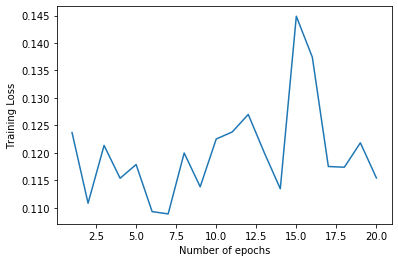

In [210]:
plt.plot(range(1,num_epochs+1),train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")

In [211]:
#Evaluating Model on test set 
test_acc=0
model.eval()

with torch.no_grad():
    #Iterating over the training dataset batches
    for i,(images,labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        outputs = outputs.squeeze()
        
        y_pred = torch.round(outputs)
        
        test_acc += (y_pred == labels).sum().item()
        
    print(f"Test set accuracy = {100*test_acc/len(test_set)}%")

Test set accuracy = 98.38957055214723%


In [212]:
#Load val set
val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])
val_set = torchvision.datasets.ImageFolder(root=val_path,transform = val_transforms)

val_loader = torch.utils.data.DataLoader(dataset=val_set)

In [213]:
#Evaluate on Validation set

val_acc=0
model.eval()

with torch.no_grad():
    #Iterating over the training dataset batches
    for i,(images,labels) in enumerate(val_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        outputs = outputs.squeeze()
        
        y_pred = torch.round(outputs)
        
        val_acc += (y_pred == labels).sum().item()
        
    print(f"Accuracy on validation set = {100*val_acc/len(val_set)}%")

Accuracy on validation set = 87.5%


## Save the model

In [216]:
torch.save(model.state_dict(),'./model.pt')

In [217]:
#Commands to load the model

#the_model = TheModelClass(*args, **kwargs)
#the_model.load_state_dict(torch.load(PATH))